#TESTING CODE IS AT THE END WITH A MARKUP THAT READS, "TESTING CODE BEGINS HERE"

In [ ]:
!pip install torch
!pip install torchvision
!pip install opencv-python

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ucsc-cse-244-a-2024-fall-final-project
!mkdir dataset
!unzip ucsc-cse-244-a-2024-fall-final-project.zip -d dataset/ucsc-cse-244-a-2024-fall-final-project
!rm -f ucsc-cse-244-a-2024-fall-final-project.zip

# number of files: train/labeled = 9854, train/unlabled = 22995, test = 8213
!ls -1 dataset/ucsc-cse-244-a-2024-fall-final-project/train/labeled | wc -l
!ls -1 dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled | wc -l
!ls -1 dataset/ucsc-cse-244-a-2024-fall-final-project/test | wc -l

import os
import shutil
import random
import pandas as pd

def create_train_validation_set(source_folder, train_folder, validation_folder, labels_csv, val_split=0.20):
    # Create train and val folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Calculate the number of validation images
    num_val_images = int(len(image_files) * val_split)

    # get data to split labels
    train_data       = []
    validation_data = []

    labels_df = pd.read_csv(labels_csv)

    # Move files to validation folder
    for i, image in enumerate(image_files):
        source_path = os.path.join(source_folder, image)
        if i < num_val_images:
            dest_path = os.path.join(validation_folder, image)
            validation_data.append(image)
        else:
            dest_path = os.path.join(train_folder, image)
            train_data.append(image)
        shutil.copy(source_path, dest_path)

    train_labels_df      = labels_df[labels_df['image'].isin(train_data)]
    validation_labels_df = labels_df[labels_df['image'].isin(validation_data)]

    train_labels_df.to_csv(os.path.join(train_folder, 'train_labels.csv'), index=False)
    validation_labels_df.to_csv(os.path.join(validation_folder, 'validation_labels.csv'), index=False)

    print(f"Moved {num_val_images} images to validation set")
    print(f"Moved {len(image_files) - num_val_images} images to training set")

# Usage
source_folder     = "dataset/ucsc-cse-244-a-2024-fall-final-project/train/labeled"
train_folder      = "dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train/"
validation_folder = "dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation"
labels_csv        = "dataset/ucsc-cse-244-a-2024-fall-final-project/train_labeled.csv"

create_train_validation_set(source_folder, train_folder, validation_folder, labels_csv)

Streaming output truncated to the last 5000 lines.
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27855.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27856.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27857.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27858.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27859.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27860.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27861.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27862.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27863.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unlabeled/27864.jpg  
  inflating: dataset/ucsc-cse-244-a-2024-fall-final-project/train/unl

In [4]:
import torch
from torch import nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import os

In [1]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader

from IPython.display import display

from matplotlib.pyplot import imshow

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    image = transforms.ToPILImage()(image)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [2]:
# Hyerparameters
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [5]:
# transfer learning using resnet50
# model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
from transformers import ViTForImageClassification, ViTFeatureExtractor
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

num_classes = 135
# categories_df = pd.read_csv('dataset/ucsc-cse-244-a-2024-fall-final-project/categories.csv')
# num_classes = categories_df.shape[0]

# update final layer with our class number
final_layer = nn.Sequential(
    nn.Linear(model.classifier.in_features, num_classes),
    nn.Softmax()
)
model.classifier = final_layer

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# train model on labeled training data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train/train_labels.csv',
                                   'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train',
                                   transform=transform
                                   )

validation_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation/validation_labels.csv',
                                     'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation',
                                     transform=transform
                                     )

train_dataloader      = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=1024, shuffle=True)

train_accs      = []
validation_accs = []

for epoch in range(epochs):
    print(f"epoch: {epoch}")

    train_loss      = 0
    train_correct   = 0
    train_total     = 0

    model.train()

    for batch, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs.logits, one_hot_labels)
        loss.backward()
        optimizer.step()

        train_loss     += loss.item()
        _, predictions  = outputs.logits.max(1)
        train_total    += labels.shape[0]
        train_correct  += predictions.eq(labels).sum().item()

    train_accuracy = train_correct / train_total
    train_accs.append(train_accuracy)
    print(f"Train accuracy for epoch number: {epoch}, is {train_accuracy}")

    validation_loss    = 0
    validation_correct = 0
    validation_total   = 0

    model.eval()

    for batch, (images, labels) in enumerate(validation_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        outputs = model(images)
        loss    = criterion(outputs.logits, one_hot_labels)

        validation_loss    += loss.item()
        _, predictions      = outputs.logits.max(1)
        validation_total   += labels.shape[0]
        validation_correct += predictions.eq(labels).sum().item()

    validation_accuracy = validation_correct / validation_total
    validation_accs.append(validation_accuracy)
    print(f"Validation accuracy for epoch number: {epoch}, is {validation_accuracy}")

    # Save the model's state dictionary
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': validation_accs,
        # Add any other relevant information you want to save
    }, f"drive/MyDrive/vit-results/vit-{epoch}.pth")

epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train accuracy for epoch number: 0, is 0.5881532217148655
Validation accuracy for epoch number: 0, is 0.7705583756345178
epoch: 1
Train accuracy for epoch number: 1, is 0.8138001014713343
Validation accuracy for epoch number: 1, is 0.8091370558375635
epoch: 2
Train accuracy for epoch number: 2, is 0.849949264332826
Validation accuracy for epoch number: 2, is 0.8091370558375635
epoch: 3
Train accuracy for epoch number: 3, is 0.8647894469812278
Validation accuracy for epoch number: 3, is 0.8279187817258883
epoch: 4
Train accuracy for epoch number: 4, is 0.8764586504312532
Validation accuracy for epoch number: 4, is 0.834010152284264
epoch: 5
Train accuracy for epoch number: 5, is 0.8895230847285642
Validation accuracy for epoch number: 5, is 0.8385786802030457
epoch: 6
Train accuracy for epoch number: 6, is 0.9067732115677322
Validation accuracy for epoch number: 6, is 0.8619289340101522
epoch: 7
Train accuracy for epoch number: 7, is 0.9221207508878742
Validation accuracy for epoch numb

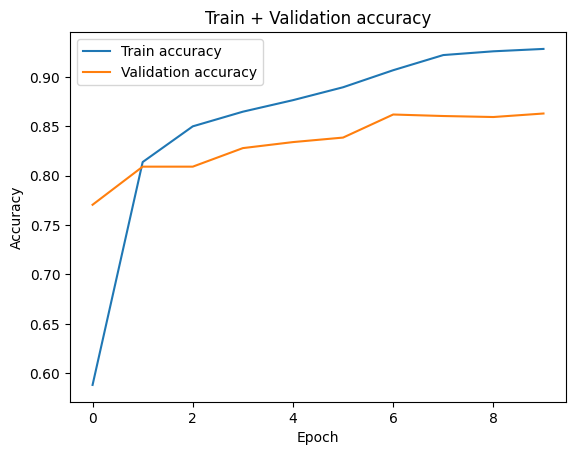

In [ ]:
plt.plot(np.arange(len(train_accs)), train_accs, label="Train accuracy")
plt.plot(np.arange(len(train_accs)), validation_accs, label="Validation accuracy")
plt.title("Train + Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("drive/MyDrive/vit-results/vit-accuracy.png")
plt.show()

In [6]:
# transfer learning using resnet50
model_resnet = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# categories_df = pd.read_csv('dataset/ucsc-cse-244-a-2024-fall-final-project/categories.csv')
# num_classes = categories_df.shape[0]

# update final layer with our class number
final_layer = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, num_classes),
    nn.Softmax()
)
model_resnet.fc = final_layer

# Freeze all layers except the final fully connected layer
for param in model_resnet.parameters():
    param.requires_grad = False
for param in model_resnet.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_resnet.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# train model on labeled training data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet.to(device)

training_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train/train_labels.csv',
                                   'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train',
                                   transform=transform
                                   )

validation_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation/validation_labels.csv',
                                     'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation',
                                     transform=transform
                                     )

train_dataloader      = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=1024, shuffle=True)

train_accs      = []
validation_accs = []

for epoch in range(epochs):
    print(f"epoch: {epoch}")

    train_loss      = 0
    train_correct   = 0
    train_total     = 0

    model_resnet.train()

    for batch, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss    = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        train_loss     += loss.item()
        _, predictions  = outputs.max(1)
        train_total    += labels.shape[0]
        train_correct  += predictions.eq(labels).sum().item()

    train_accuracy = train_correct / train_total
    train_accs.append(train_accuracy)
    print(f"Train accuracy for epoch number: {epoch}, is {train_accuracy}")

    validation_loss    = 0
    validation_correct = 0
    validation_total   = 0

    model_resnet.eval()

    for batch, (images, labels) in enumerate(validation_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        outputs = model_resnet(images)
        loss    = criterion(outputs, one_hot_labels)

        validation_loss    += loss.item()
        _, predictions      = outputs.max(1)
        validation_total   += labels.shape[0]
        validation_correct += predictions.eq(labels).sum().item()

    validation_accuracy = validation_correct / validation_total
    validation_accs.append(validation_accuracy)
    print(f"Validation accuracy for epoch number: {epoch}, is {validation_accuracy}")

    # Save the model's state dictionary
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': validation_accs,
        # Add any other relevant information you want to save
    }, f"drive/MyDrive/resnet-results/resnet-{epoch}.pth")

epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train accuracy for epoch number: 0, is 0.2633181126331811
Validation accuracy for epoch number: 0, is 0.4781725888324873
epoch: 1
Train accuracy for epoch number: 1, is 0.624048706240487
Validation accuracy for epoch number: 1, is 0.7025380710659899
epoch: 2
Train accuracy for epoch number: 2, is 0.7838660578386606
Validation accuracy for epoch number: 2, is 0.7817258883248731
epoch: 3
Train accuracy for epoch number: 3, is 0.858701166920345
Validation accuracy for epoch number: 3, is 0.8142131979695432
epoch: 4
Train accuracy for epoch number: 4, is 0.8939624556062912
Validation accuracy for epoch number: 4, is 0.8385786802030457
epoch: 5
Train accuracy for epoch number: 5, is 0.9160324708269914
Validation accuracy for epoch number: 5, is 0.8451776649746193
epoch: 6
Train accuracy for epoch number: 6, is 0.9316336884830035
Validation accuracy for epoch number: 6, is 0.8705583756345178
epoch: 7
Train accuracy for epoch number: 7, is 0.941400304414003
Validation accuracy for epoch numbe

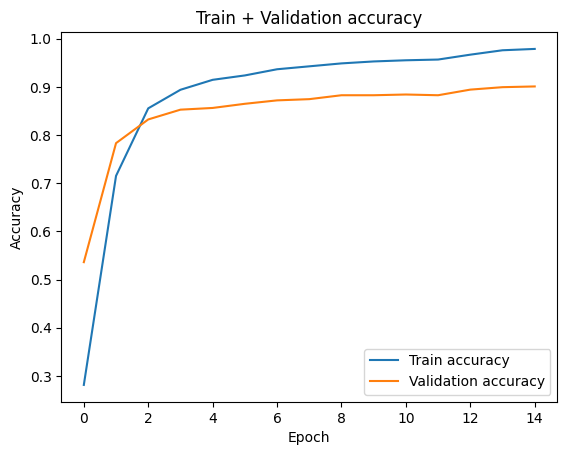

In [ ]:
plt.plot(np.arange(len(train_accs)), train_accs, label="Train accuracy")
plt.plot(np.arange(len(train_accs)), validation_accs, label="Validation accuracy")
plt.title("Train + Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("drive/MyDrive/resnet-results/resnet-accuracy.png")
plt.show()

In [7]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
# make ensemble of resnet and vit
class WeightedEnsemble(nn.Module):
    def __init__(self, model_resnet, model_vit, weight=0.5):
        super().__init__()
        self.resnet = model_resnet
        self.vit    = model_vit

        self.weight = nn.Parameter(torch.tensor(weight))

    def forward(self, x):
        output_resnet = self.resnet(x)
        output_vit    = self.vit(x).logits
        normalized_weight = nn.Sigmoid()(self.weight)
        weighted_output = (normalized_weight) * output_resnet + (1 - normalized_weight) * output_vit
        return weighted_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the models
checkpoint = torch.load(f"/content/vit_model.pth", map_location = device)
model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(f"/content/resnet_model.pth", map_location = device)
model_resnet.load_state_dict(checkpoint['model_state_dict'])

# Create an instance of the ensemble model
ensemble_model = WeightedEnsemble(model_resnet, model)
ensemble_model.to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for probability outputs
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

<ipython-input-7-f8408af098c5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"/content/vit_model.pth", map_location = device)
<ipython-input-7-f

In [22]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"

In [8]:
ensemble_model.to(device)

training_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train/train_labels.csv', 'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/train', transform=transform )
validation_data = CustomImageDataset('dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation/validation_labels.csv', 'dataset/ucsc-cse-244-a-2024-fall-final-project/milind/validation', transform=transform )

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

train_accs = []
validation_accs = []

for epoch in range(epochs):
    print(f"epoch: {epoch}")

    train_loss      = 0
    train_correct   = 0
    train_total     = 0

    ensemble_model.train()

    for batch, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        optimizer.zero_grad()
        outputs = ensemble_model(images)
        loss    = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        train_loss     += loss.item()
        _, predictions  = outputs.max(1)
        train_total    += labels.shape[0]
        train_correct  += predictions.eq(labels).sum().item()

    train_accuracy = train_correct / train_total
    train_accs.append(train_accuracy)
    print(f"Train accuracy for epoch number: {epoch}, is {train_accuracy}")

    validation_loss    = 0
    validation_correct = 0
    validation_total   = 0

    ensemble_model.eval()

    for batch, (images, labels) in enumerate(validation_dataloader):
        images, labels = images.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        outputs = ensemble_model(images)
        loss    = criterion(outputs, one_hot_labels)

        validation_loss    += loss.item()
        _, predictions      = outputs.max(1)
        validation_total   += labels.shape[0]
        validation_correct += predictions.eq(labels).sum().item()

    validation_accuracy = validation_correct / validation_total
    validation_accs.append(validation_accuracy)
    print(f"Validation accuracy for epoch number: {epoch}, is {validation_accuracy}")

# Save the model's state dictionary
    print([param.data for name, param in ensemble_model.named_parameters() if name == 'weight'])


epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train accuracy for epoch number: 0, is 0.9420345002536783
Validation accuracy for epoch number: 0, is 0.9477157360406091
[tensor(0.4096, device='cuda:0')]
epoch: 1
Train accuracy for epoch number: 1, is 0.9577625570776256
Validation accuracy for epoch number: 1, is 0.9568527918781726
[tensor(0.3223, device='cuda:0')]
epoch: 2
Train accuracy for epoch number: 2, is 0.9714611872146118
Validation accuracy for epoch number: 2, is 0.9558375634517766
[tensor(0.2380, device='cuda:0')]
epoch: 3
Train accuracy for epoch number: 3, is 0.9785641806189751
Validation accuracy for epoch number: 3, is 0.9558375634517766
[tensor(0.1631, device='cuda:0')]
epoch: 4
Train accuracy for epoch number: 4, is 0.9828767123287672
Validation accuracy for epoch number: 4, is 0.9649746192893401
[tensor(0.0939, device='cuda:0')]
epoch: 5
Train accuracy for epoch number: 5, is 0.9861745306950787
Validation accuracy for epoch number: 5, is 0.9619289340101523
[tensor(0.0211, device='cuda:0')]
epoch: 6
Train accuracy f

In [10]:
torch.save(ensemble_model, f"ensemble_model")
#torch.save(f"ensemble_model", ensemble_model)

In [ ]:
for name, param in ensemble_model.named_parameters():
    if "weight" == name:
      print(param.data)

tensor(0.7386, device='cuda:0')


#TESTING CODE BEGINS HERE

In [2]:
#Code to download the ensemble model from drive link

import torch
import gdown

# Google Drive shared link



shared_link = "https://drive.google.com/file/d/1VgAOMFnHlQD2HkJkR-tWnesUF1kjPszo/view?usp=sharing"

file_id = "1VgAOMFnHlQD2HkJkR-tWnesUF1kjPszo"
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output_path = "ensemble_model"  # Specify the desired local file name
gdown.download(download_url, output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1VgAOMFnHlQD2HkJkR-tWnesUF1kjPszo
From (redirected): https://drive.google.com/uc?id=1VgAOMFnHlQD2HkJkR-tWnesUF1kjPszo&confirm=t&uuid=711388ac-e37f-4b38-b8f7-26f090a54499
To: /content/ensemble_model
100%|██████████| 516M/516M [00:13<00:00, 39.4MB/s]


'ensemble_model'

In [10]:
# #Testing code
#Make sure to change the test directory alone before running it


from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch import nn
import os
import pandas as pd

# # make ensemble of resnet and vit
class WeightedEnsemble(nn.Module):
    def __init__(self, model_resnet, model_vit, weight=0.5):
        super().__init__()
        self.resnet = model_resnet
        self.vit    = model_vit

        self.weight = nn.Parameter(torch.tensor(weight))

    def forward(self, x):
        output_resnet = self.resnet(x)
        output_vit    = self.vit(x).logits
        normalized_weight = nn.Sigmoid()(self.weight)
        weighted_output = (normalized_weight) * output_resnet + (1 - normalized_weight) * output_vit
        return weighted_output

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


# resnet_model_path = '/content/resnet_model.pth'
# vit_model_path = '/content/vit_model.pth'


# #Loading resnet model
# model_resnet = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# num_classes = 135


# final_layer = nn.Sequential(
#     nn.Linear(model_resnet.fc.in_features, num_classes),
#     nn.Softmax()
# )
# model_resnet.fc = final_layer

# resnet_checkpoint = torch.load("resnet_model.pth", map_location = device)
# model_resnet.load_state_dict(resnet_checkpoint['model_state_dict'])


# #Loading vit model

# from transformers import ViTForImageClassification, ViTFeatureExtractor
# model_vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


# final_layer = nn.Sequential(
#     nn.Linear(model_vit.classifier.in_features, num_classes),
#     nn.Softmax()
# )
# model_vit.classifier = final_layer

# vit_checkpoint = torch.load("vit_model.pth", map_location = device)
# model_vit.load_state_dict(vit_checkpoint['model_state_dict'])

ensemble_model = torch.load("ensemble_model")
ensemble_model.weight = nn.Parameter(torch.tensor(-0.3186))
ensemble_model.to(device)

#Replace with the path where the images are at
test_dir = 'dataset/ucsc-cse-244-a-2024-fall-final-project/test'

class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = read_image(img_path)
        image = transforms.ToPILImage()(image)
        label = self.image_files[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_data = TestImageDataset(test_dir, transform=transform)

test_dataloader = DataLoader(test_data, batch_size=256)

results = {
    'image': [],
    'id': []
}

# checkpoint = torch.load(f"drive/MyDrive/resnet-results/resnet-9.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
ensemble_model.eval()

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dataloader):
        images  = images.to(device)
        outputs = ensemble_model(images)

        _, predictions  = outputs.max(1)

        results['image'].extend(list(labels))
        results['id'].extend(predictions.tolist())

results_df = pd.DataFrame.from_dict(results)
results_df.to_csv('resnet_vit_ensemble_submission.csv', index=False)
print("Saved results successfully")

Saved results successfully
